Paper & data
https://arxiv.org/pdf/0907.0019.pdf

http://maia.ice.cat/mice/

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import numpy as np
from skypy.halo import mass
from skypy.power_spectrum import growth_function, camb
from astropy.cosmology import FlatLambdaCDM

In [3]:
from pysampler.generate import sampler, statistics

### THE MASS FUNCTION

In [4]:
cosmo = FlatLambdaCDM(H0=70.0, Om0=0.25, Ob0=0.044, Tcmb0=2.725)
D0 = growth_function(0, cosmo) / growth_function(0, cosmo)

In [5]:
k = np.logspace(-3, 1, num=1000, base=10.0)
A_s, n_s = 2.1982e-09, 0.95
h = cosmo.H0.value/100
Pk = camb(k, 1e-10, cosmo, A_s, n_s) 

In [6]:
m = np.logspace(13.0, 15.5) /h # Msun/h
PS = mass.press_schechter_mass_function(m, k, Pk, D0, cosmo) * h**4 #h^4 Mpc^{-3} M^{-1}
ST = mass.sheth_tormen_mass_function(m, k, Pk, D0, cosmo) * h**4

In [7]:
def f_mice0(sigma, params):
    A, a, b, c = params
    return A * (np.power(sigma, -a) + b) * np.exp(-c / sigma**2)

In [8]:
params_mice = (0.58, 1.37, 0.3, 1.036)
s = np.sqrt(mass._sigma_squared(m, k, Pk, 1, cosmo))
mfmice = mass.halo_mass_function(m, k, Pk, D0, cosmo, f_mice0, params=params_mice) * h**4

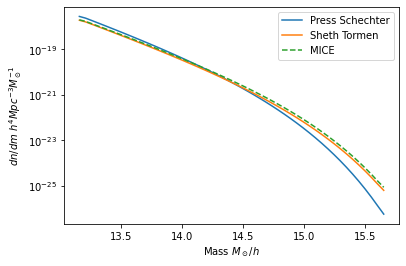

In [9]:
plt.plot(np.log10(m), PS, label='Press Schechter')
plt.plot(np.log10(m), ST, label='Sheth Tormen')
plt.plot(np.log10(m), mfmice, '--', label='MICE')

plt.xlabel(r'Mass $M_\odot/h$')
plt.ylabel(r'$dn / dm$ $h^4 Mpc^{-3} M^{-1}_\odot$')

plt.yscale('log')
plt.legend()
plt.show()

### THE SIMULATION

In [13]:
def mfM(mx):
    return np.interp(mx, m, mfmice)
def mfPS(mx):
    return np.interp(mx, m, PS)
def mfST(mx):
    return np.interp(mx, m, ST)

In [14]:
msampleM = []
msamplePS = []
msampleST = []
for i in range(10):
    sample = sampler(mfM, 1e13,1e15,resolution=1000, size=1000000)
    msampleM.append(sample)
    
for i in range(10):
    sample = sampler(mfPS, 1e13,1e15,resolution=1000, size=1000000)
    msamplePS.append(sample)
    
for i in range(10):
    sample = sampler(mfST, 1e13,1e15,resolution=1000, size=1000000)
    msampleST.append(sample)

In [15]:
log_min = 13.5
log_max = 15.5

nbins = round((log_max - log_min)/0.1)

In [16]:
average_sampleM, bin_centerM, meanM, stdM = statistics(np.log10(msampleM), nbins)
average_samplePS, bin_centerPS, meanPS, stdPS = statistics(np.log10(msamplePS), nbins)
average_sampleST, bin_centerST, meanST, stdST = statistics(np.log10(msampleST), nbins)

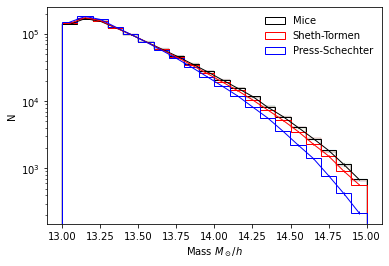

In [17]:
for mm in msampleM:
    plt.hist(np.log10(mm), bins=nbins, histtype='step', lw=0.1)

plt.hist(average_sampleM, bins=nbins, histtype='step', color='k', label='Mice')
plt.errorbar(bin_centerM, meanM, yerr=stdM, color='k', lw=1) 

plt.hist(average_sampleST, bins=nbins, histtype='step', color='r', label='Sheth-Tormen')
plt.errorbar(bin_centerST, meanST, yerr=stdST, color='r', lw=1)

plt.hist(average_samplePS, bins=nbins, histtype='step', color='b', label='Press-Schechter')
plt.errorbar(bin_centerPS, meanPS, yerr=stdPS, color='b', lw=1)

plt.ylabel('N')
plt.xlabel(r'Mass $M_\odot/h$')

plt.yscale('log')
plt.legend(frameon=False)
plt.show()